In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import os

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [4]:
with open('Data/Data12_1/GB_result_12I1O_1.pkl', 'rb') as f:
    result = pickle.load(f)

In [5]:
df_r = pd.DataFrame(result)

In [6]:
r2 = df_r[3].apply(pd.Series)

The below graph shows how R<sup>2</sup> and RMSE change throughout each iteration. "Iteration 0" is the basic DEA without any constarints while the other iterations have constraints extracted from ML feature importance.

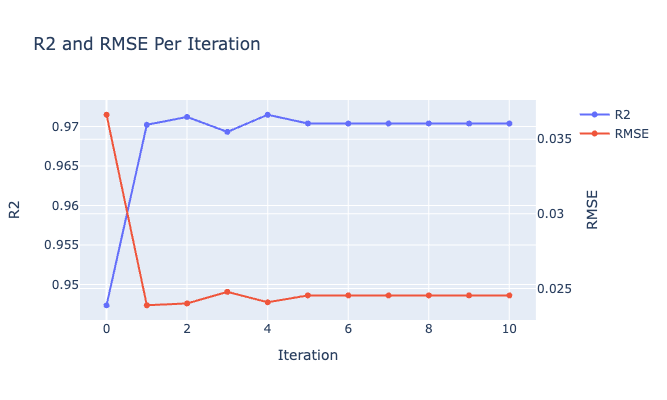

In [7]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(go.Scatter(y =  r2.r2, x = r2.index, name = "R2"),  secondary_y=False)
fig.add_trace(go.Scatter(y =  r2.neg_root_mean_squared_error * -1, x = r2.index, name = "RMSE"), secondary_y=True)


fig.update_layout(title="R2 and RMSE Per Iteration",
                    xaxis_title='Iteration',
                    yaxis_title='R2',
                    yaxis2_title='RMSE',
                   autosize=False,
                   width=700,
                  height=400,
                 )
fig.update_layout(title_text = "R2 and RMSE Per Iteration")

fig.show()

The below graph shows how zero counts change throughout each iteration.

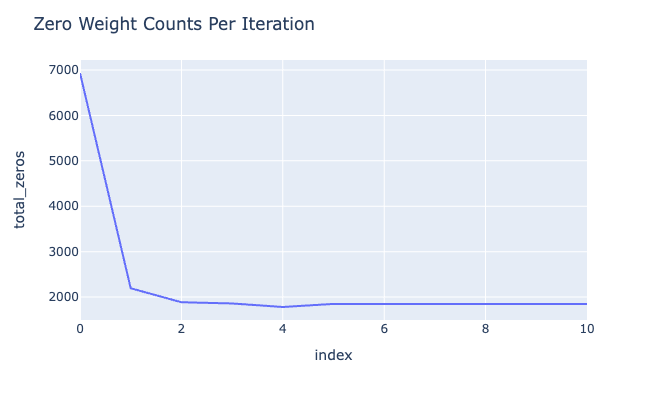

In [8]:
fig = px.line(r2, x=r2.index, y=r2.total_zeros)

fig.update_layout(
    autosize=False,
    width=700,
    height=400,
    title_text=f"Zero Weight Counts Per Iteration",
)

fig.show()

In [9]:
df_imp = pd.read_pickle('Data/Data12_1/GB_12I1O_1_df_imp.pkl')

The below bar graph shows how feature importance of Inputs and Output change throughout each iteration.

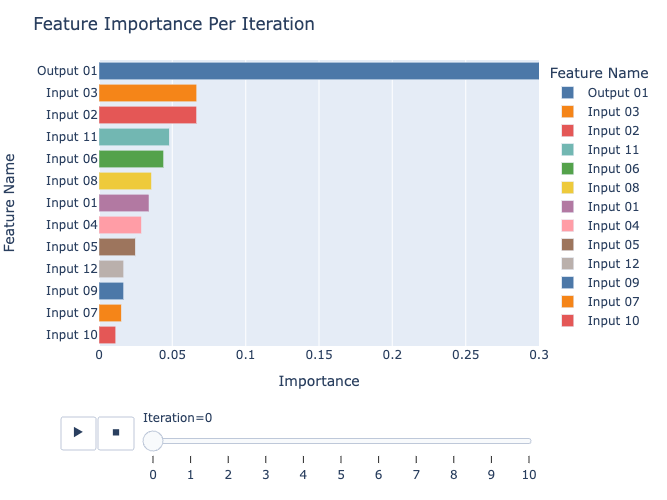

In [10]:
fig = px.bar(
    df_imp,
    y="Feature Name",
    x="Importance",
    color="Feature Name",
    color_discrete_sequence=px.colors.qualitative.T10,
    animation_frame="Iteration",
    animation_group="Feature Name",
    orientation="h",
    range_x=[0,0.3]
)

fig.update_yaxes(categoryorder='total ascending')

fig.update_layout(
    autosize=False,
    width=700,
    height=500,
    title_text=f"Feature Importance Per Iteration",
)


fig.show()

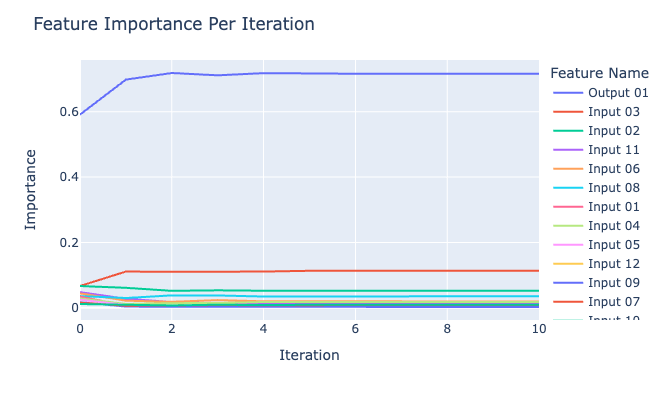

In [11]:
fig = px.line(df_imp, x='Iteration', y="Importance", color = "Feature Name")

fig.update_layout(
    autosize=False,
    width=700,
    height=400,
    title_text=f"Feature Importance Per Iteration",
)

fig.show()

In [12]:
folder = "Data/Data12_1/"

In [13]:
files_es = sorted([f for f in os.listdir(folder) if os.path.splitext(f)[1]==".xlsx"], key = lambda x: len(x))
files_es = [files_es[0]] + sorted(files_es[1:-1]) + [files_es[-1]]

In [14]:
df_es = pd.DataFrame()

for i, f in enumerate(files_es):
    df_temp = pd.read_excel(folder + f, index_col=0, usecols="A:B")
    n = os.path.splitext(f)[0][-1] if i!=10 else os.path.splitext(f)[0][-2:]
    df_temp.columns = [f"{n}"]
    df_es = pd.concat([df_es, df_temp], axis=1)

The below line graph shows how Efficiency Score of DMUs changes per iteration. You can use dropdown menu on the right upper corner to change DMU group.

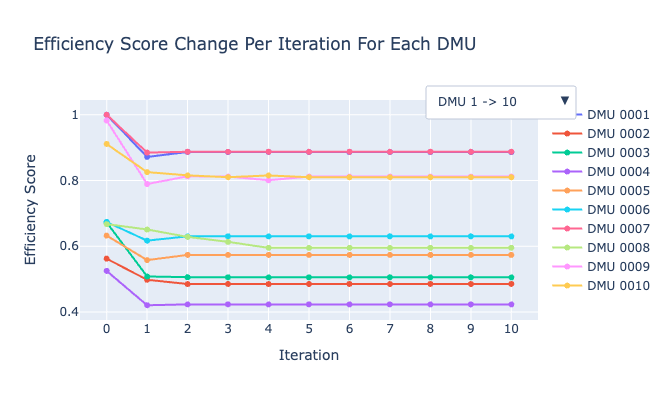

In [15]:
default_dmu_group = 1

# dd=go.Figure()

dd = go.Figure()
buttons=[]
plot_names = list(range(1,1001))


for ind in range(1,1001, 10):
    
    start = ind - 1
    end = start + 10

    df_temp = df_es.iloc[start:end]  
    
    for _,row in df_temp.iterrows():
        dd.add_trace(go.Scatter(x=df_es.columns, y=row, name = row.name,
                                visible=(int(row.name.split()[1]) <= default_dmu_group * 10)))

    buttons.append(dict(method='update',
                        label="DMU " + str(ind) + " -> " + str(ind + 9),
                        args = [{'visible': [i in range(ind,ind +10) for i in plot_names]}]))
    
# Add dropdown menus to the figure
dd.update_layout(showlegend=True, updatemenus=[{"buttons": buttons, "direction": "down", "active": 0, "showactive": True, "x": 1.08, "y": 1.07}])
dd.update_layout(title_text = "Efficiency Score Change Per Iteration For Each DMU",
                yaxis_title="Efficiency Score",
                xaxis_title="Iteration",
                    autosize=False,
                width=700,
                height=400)
dd.show()

In [16]:
eDMU = (df_es==1).sum().to_frame()
eDMU.reset_index(inplace=True)
eDMU.columns = ["Iteration", "Count"]

The below line graph shows how Efficient DMU counts change per iteration.

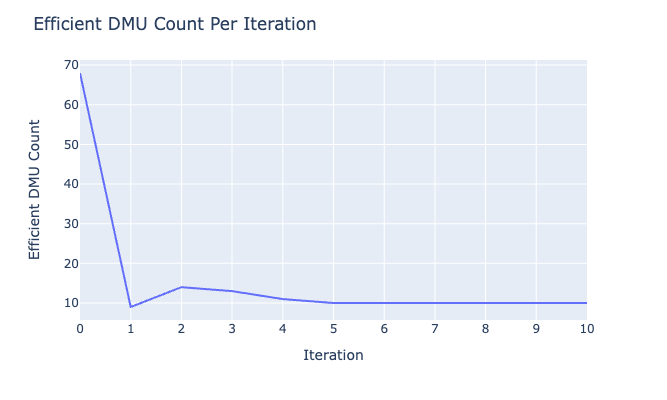

In [17]:
fig = px.line(eDMU, x="Iteration", y="Count")

fig.update_layout(
    autosize=False,
    width=700,
    height=400,
    title_text = "Efficient DMU Count Per Iteration",
    yaxis_title="Efficient DMU Count",)


fig.show()

In [18]:
df_melted = pd.melt(df_es)
df_melted.columns = ["Iteration", "ES"]

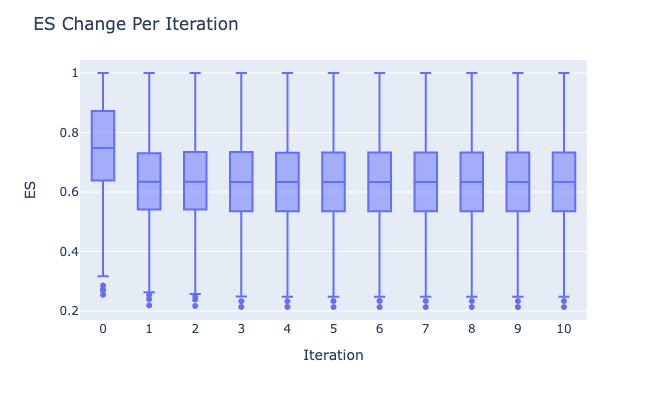

In [19]:
fig = px.box(df_melted, x = "Iteration", y = "ES")

fig.update_layout(
    autosize=False,
    width=1200,
    height=400,
    title_text=f"ES Change Per Iteration"
)

fig .show()